In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix as csr
from scipy.sparse import lil_matrix as lil
from scipy.sparse import kron
from scipy.sparse.linalg import eigs, eigsh
import timeit
import scipy.sparse as sps
from numpy import linalg as LA
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Lanczos

In [2]:
def Lanczos(OL,OR,n_eigvals,max_iter,init_vec):
    
    #Function for diagonalizing superblock Hamiltonian of our systems
    #using Left block & Right block Operators without calculating their kron product

    num_terms = len(OL) #number of terms in superblock Hamiltonian

    Dim_L = np.size(OL[0], axis = 1) #left operators dimension
    Dim_R = np.size(OR[0], axis = 1) #right operators dimension

    Dim_tot = Dim_L*Dim_R #superblock Hamiltonian dimension

    v_prev = init_vec #initial vector for lanczos
    
    vec = np.zeros((max_iter+3,Dim_tot)) #storing the vectors in Krylov space
    vec[1,:] = v_prev
    
    beta = np.zeros(max_iter+3)
    alpha = np.zeros(max_iter+3)
    
    D0 = np.zeros(n_eigvals) # storing eigenvalues at each iteration and checking convergence
    j_min = 2*n_eigvals + 2  # minimun number of iterations 
    tol = 10**(-10) # if the difference between eigenvalues in current and previous iteration is less than tol
    #then we have reached convergence and we can break the loop
    
    #Main loop:
    for j in range(1,max_iter+2):
        
        v_first = vec[j-1,:] #v_0
        v_prev = vec[j,:] #v_1
        # here we don't have the superblock Hamiltonian matrix, instead we have the left & right operators 
        # that by calculating their kron product we can get the superblock Hamiltonian matrix
        # but we don't want to use kron product because it's not efficient
        # instead we reshape v_prev into Dim_L & Dim_R, then take the i-th
        # component of O_L and O_R lists, and multiply O_L{i} from the left and
        # transpose of O_R{i} from the right and then take sum over i's.
        # This yields the reshape of v_next (as a matrix) 
        # by an additional reshape we can change its dimension to be a vector
        
        v_prev = np.reshape(v_prev,(Dim_L,Dim_R))
        
        #new vector:
        v_next = 0
        for i in range(num_terms):
            v_next = v_next + OL[i]*v_prev*np.transpose(OR[i])
        #v_2 = OL[1]*v_1*OR'[1] + OL[2]*v_1*OR'[2] + OL[3]*v_1*OR'[3] + ...

        v_prev = np.reshape(v_prev,(1,-1))   #reshape to be a vector
        v_next = np.reshape(v_next,(1,-1))   #reshape to be a vector
        v_first = np.reshape(v_first,(1,-1)) #reshape to be a vector 


        #the resulting vector has an overlap with v_prev:
        alpha[j] = np.dot(v_prev,v_next.transpose())
       
        
        v_next = v_next - alpha[j]*v_prev - beta[j]*v_first

        # Gram-Schmidt method to re-orthogonalize vectors:
        for i in range(0,j-1):
            overlap = np.transpose(vec[i,:]) * v_next
            v_next = v_next - vec[i,:] * overlap

        beta_temp = np.linalg.norm(v_next)
        beta[j+1] = np.copy(beta_temp) 
        
        if beta_temp < 10**(-17): #there is no need to construct another vector
            break  
            
        v_next = v_next/beta_temp
        vec[j+1,:] = v_next
        
        D0_prev = D0
        
        #if convergence has reached then break the loop
        #constructing the tri-diagonal matrix T, using alpha and beta:
        T0 = lil(np.zeros((j+1,j+1)))
        for i in range(1,j+1):
            T0[i-1,i-1] = alpha[i]
            T0[i-1,i] = beta[i+1]
            T0[i,i-1] = beta[i+1]

        T0[j,j] = alpha[j+1]
        D0,U0= eigsh(T0,k = n_eigvals, which = 'SA')
        if j > j_min and np.sum(abs(D0 - D0_prev)) < tol:
            break
        
    #constructing the tri-diagonal matrix T, using alpha and beta
    T = lil(np.zeros((j+1,j+1)))
    for i in range(1,j+1):
        T[i-1,i-1] = alpha[i]
        T[i-1,i] = beta[i+1]
        T[i,i-1] = beta[i+1]

    T[j,j] = alpha[j+1]
    
    #computing the eigenvectors and eigenvalues of tri-diagonal matrix T
    D_T,U_T =  eigsh(T,k = n_eigvals, which = 'SA')

    #Computing the eigenvalues and eigen-vectors of Hamiltonian using those of T
    V = np.dot(vec[0:j+1,:].transpose(),U_T)
    E = D_T
    
    return E,V

# DMRG

In [7]:
bc = 0 #boundary condition
t = 1 #hopping term
U = 0.2
Lambda = 10**3

n_kept_states = 15 # Number of states kept

# Number of iterations.  Final lattice size is 2*n_iter + 2
n_iter = 25
System_Size = 2*n_iter+2 #number of unitcells ( number of sites = 2*system_size)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# 2 * 2  Operators in for single site
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Creation and Annihilation Operators:
C = csr(np.array([[0,1],[0,0]])) #annihilation operator -> sigma_minus
C_dag = csr(np.transpose(C))     #creation operator -> sigma_plus

# Number Operator:
n = C_dag*C

#Identity matrix
I_d = csr(np.eye(2))
I = csr(np.eye(4))

#Sigma_z
z = csr(np.array([[1,0],[0,-1]]))
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#              Initial blocks
#               We assume reflection symmetry so we only need 1 block
#               The operator acts on the inner-most site of the block
#               +---------+    +---------+
#               |       #*|    |*#       |
#               +---------+    +---------+
#               odd sites are spin up and evens represent spin downs
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Each site is considered to be a unitcell that the left side is spin-down and the right side is spin-up

C_up = csr(kron(z,C))       #second site in unitcell
C_down = csr(kron(C,I_d))   #first site in unitcell

C_up_dag = csr.transpose(C_up)
C_down_dag = csr.transpose(C_down)

n_up = csr(kron(I_d,n))
n_down = csr(kron(n,I_d))

Z = kron(z,z)

# Operators for last site added to block 
#%%%%%%%%% Left %%%%%%%%%%%%
Cu_first_L = csr.copy(C_up)
Cud_first_L = csr.copy(C_up_dag)

Cd_first_L = csr.copy(C_down)
Cdd_first_L = csr.copy(C_down_dag)

n_up_last_L = csr.copy(n_up)
n_down_last_L = csr.copy(n_down)

block_Id_L  = csr.copy(I)
block_Z_L = csr.copy(Z)

#%%%%%%%%% Right %%%%%%%%%%%%
Cu_first_R = csr.copy(C_down)
Cud_first_R = csr.copy(C_down_dag)

Cd_first_R = csr.copy(C_up)
Cdd_first_R = csr.copy(C_up_dag)

n_up_last_R = csr.copy(n_down)
n_down_last_R = csr.copy(n_up)

block_Id_R  = csr.copy(I)
block_Z_R = csr.copy(Z)

# one site Hamiltonian
block_H_L = U*(n_up*n_down)

block_H_R = U*(n_down*n_up)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#  initializing a few useful quantities
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

EE = np.zeros(n_iter) # Entanglement Entropy
system_size = np.zeros(n_iter)
truncation_error = np.zeros(n_iter)
energy_per_bond = np.zeros(n_iter)
Check = np.zeros(n_iter) #Cheking that [H,N] = 0

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#    number operators, creation & annihilation operators and correlation functions
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
N_up_L = dict() ;N_down_L = dict()   
N_up_R = dict() ;N_down_R = dict() 

max_length_left_block = n_iter + 1

C_d_L= dict() ;C_u_L = dict()   
C_d_R= dict() ;C_u_R = dict() 

C_dag_d_L= dict() ;C_dag_u_L = dict()   
C_dag_d_R= dict() ;C_dag_u_R = dict()  

CC_up_L = {}; CC_down_L = {}
CC_up_R = {}; CC_down_R = {}


#Initializing
N_up_L[0] = n_up       
N_down_L[0] = n_down
N_up_R[0] = n_down
N_down_R[0] = n_up

C_u_L[0] = C_up
C_d_L[0] = C_down
C_u_R[0] = C_down
C_d_R[0] = C_up

C_dag_u_L[0] = C_u_L[0].T
C_dag_d_L[0] = C_d_L[0].T
C_dag_u_R[0] = C_u_R[0].T
C_dag_d_R[0] = C_d_R[0].T

       
for i in range(max_length_left_block):
    CC_up_L[i] = {}
    CC_down_L[i] = {}
    
    CC_up_R[i] = {}
    CC_down_R[i] = {}
    for j in range(max_length_left_block):
        if i==0 and j==0:
            CC_up_L[i][j] = C_up_dag*C_up
            CC_down_L[i][j] = C_down_dag*C_down
            
            CC_up_R[i][j] = C_down_dag*C_down
            CC_down_R[i][j] = C_up_dag*C_up
            
        if i==0 and j!=0:
            CC_up_L[i][j] = C_up_dag*Z
            CC_down_L[i][j] = C_down_dag*Z
    
            CC_up_R[i][j] = C_down_dag*Z
            CC_down_R[i][j] = C_up_dag*Z
            
        if j==0 and i!=0:
            CC_up_L[i][j] = Z*C_up
            CC_down_L[i][j] = Z*C_down
            
            CC_up_R[i][j] = Z*C_down
            CC_down_R[i][j] = Z*C_up
            
        else:
            CC_up_L[i][j] = Z*Z
            CC_down_L[i][j] = Z*Z
            
            CC_up_R[i][j] = Z*Z
            CC_down_R[i][j] = Z*Z

In [8]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Begin main iterations
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
spin_up = 1
spin_down = 1

for l in range(n_iter):
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #       Get the 2*chi-dimensional operators for the block +
    #       site where chi = n_kept_states
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%%% Left Block Operators %%%%%%%%%%%
    n_up_last_L = kron (block_Id_L , n_up)
    n_down_last_L = kron (block_Id_L , n_down)
    
    Cu_last_L = kron (block_Z_L , C_up)         #C_up{i+1}
    Cud_last_L = kron (block_Z_L , C_up_dag)    #C_up{i+1}^\dag
    
    Cd_last_L = kron (block_Z_L , C_down)       #C_down{i+1}
    Cdd_last_L = kron (block_Z_L , C_down_dag)  #C_down{i+1}^\dag
    
    Cu_first_L = kron (Cu_first_L , I)   #C_up{i}
    Cud_first_L = kron (Cud_first_L , I) #C_up{i}^\dag 
    
    Cd_first_L = kron (Cd_first_L , I)   #C_down{i}
    Cdd_first_L = kron (Cdd_first_L , I) #C_down{i}^\dag
    
    #%%%%%%%%%%% Building left block hamiltonian %%%%%%%%%%%
    block_H_L = kron (block_H_L , I) + U * (n_up_last_L * n_down_last_L)\
    -t * ((Cud_last_L * Cu_first_L) + (Cud_first_L * Cu_last_L)\
        +(Cdd_last_L * Cd_first_L) + (Cdd_first_L * Cd_last_L))
    
    block_Id_L = kron (block_Id_L , I) 
    block_Z_L = kron (block_Z_L , Z)
    
    #%%%%%%%% Right Block Operators %%%%%%%%%%%%%%
    n_up_last_R = kron (block_Id_R , n_down)
    n_down_last_R = kron (block_Id_R , n_up)
    
    Cu_last_R = kron (block_Z_R , C_down)      #C_up{i+1}
    Cud_last_R = kron (block_Z_R , C_down_dag) #C_up{i+1}^\dag
    
    Cd_last_R = kron (block_Z_R , C_up)      #C_down{i+1}
    Cdd_last_R = kron (block_Z_R , C_up_dag) #C_down{i+1}^\dag
    
    Cu_first_R = kron (Cu_first_R , I)   #C_up{i}
    Cud_first_R = kron (Cud_first_R , I) #C_up{i}^\dag 
    
    Cd_first_R = kron (Cd_first_R , I)   #C_down{i}
    Cdd_first_R = kron (Cdd_first_R , I) #C_down{i}^\dag
    
    #%%%%%%%%%%%% Building right block hamiltonian %%%%%%%%%%
    block_H_R = kron (block_H_R , I) + U * (n_up_last_R * n_down_last_R)\
    -t * ((Cud_last_R * Cu_first_R) + (Cud_first_R * Cu_last_R)\
        +(Cdd_last_R * Cd_first_R) + (Cdd_first_R * Cd_last_R))
                    
    block_Id_R = kron (block_Id_R , I) 
    block_Z_R = kron (block_Z_R , Z)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Updating Operators at each site for left and right block
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    left_block_length = l + 1
    
    #%%%%%%%%%%%%%%%%%%%
    #  Number operators
    #%%%%%%%%%%%%%%%%%%%
    # for each site
    for x in range(left_block_length):

        N_up_L[x] = kron(N_up_L[x],I)
        N_down_L[x] = kron(N_down_L[x],I)
        N_up_R[x] = kron(N_up_R[x],I)
        N_down_R[x] = kron(N_down_R[x],I)
        
    N_up_L[left_block_length] = n_up_last_L
    N_down_L[left_block_length] = n_down_last_L
    N_up_R[left_block_length] = n_up_last_R
    N_down_R[left_block_length] = n_down_last_R
    
    dim_n = np.size(N_up_L[0],axis=1)
    
    #Total number operator for left and right block:
    N_Left = csr((dim_n,dim_n)) 
    N_Right = csr((dim_n,dim_n))
    
    for i in range(left_block_length+1):
        N_Left += N_up_L[i] + Lambda*N_down_L[i]
        N_Right += N_up_R[i] + Lambda*N_down_R[i]
        
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Creation & Annihilation operators at each site
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    for x in range(left_block_length):
    
        C_u_L[x] = kron(C_u_L[x],I)
        C_d_L[x] = kron(C_d_L[x],I)
        
        C_u_R[x] = kron(C_u_R[x],I)
        C_d_R[x] = kron(C_d_R[x],I)

        C_dag_u_L[x] = C_u_L[x].T
        C_dag_d_L[x] = C_d_L[x].T
        
        C_dag_u_R[x] = C_u_R[x].T
        C_dag_d_R[x] = C_d_R[x].T   
        
    C_u_L[left_block_length] = Cu_last_L
    C_d_L[left_block_length] = Cd_last_L
    
    C_u_R[left_block_length] = Cu_last_R
    C_d_R[left_block_length] = Cd_last_R
    
    
    C_dag_u_L[left_block_length] = Cud_last_L
    C_dag_d_L[left_block_length] = Cdd_last_L
    
    C_dag_u_R[left_block_length] = Cud_last_R
    C_dag_d_R[left_block_length] = Cdd_last_R
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # Composite product operators for Green's function calcualtion in left & right block
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    for i in range(max_length_left_block):
        for j in range(max_length_left_block):
            
            if i == left_block_length:
                if j == left_block_length:
                    CC_up_L[i][j] = kron(CC_up_L[i][j],C_up_dag*C_up)
                    CC_down_L[i][j] = kron(CC_down_L[i][j],C_down_dag*C_down)
                    
                    CC_up_R[i][j] = kron(CC_up_R[i][j],C_down_dag*C_down)
                    CC_down_R[i][j] = kron(CC_down_R[i][j],C_up_dag*C_up)

                elif j < left_block_length:
                    CC_up_L[i][j] = kron(CC_up_L[i][j],C_up_dag*I)
                    CC_down_L[i][j] = kron(CC_down_L[i][j],C_down_dag*I)
                    
                    CC_up_R[i][j] = kron(CC_up_R[i][j],C_down_dag*I)
                    CC_down_R[i][j] = kron(CC_down_R[i][j],C_up_dag*I)

                elif j > left_block_length :
                    CC_up_L[i][j] = kron(CC_up_L[i][j],C_up_dag*Z)
                    CC_down_L[i][j] = kron(CC_down_L[i][j],C_down_dag*Z)
                    
                    CC_up_R[i][j] = kron(CC_up_R[i][j],C_down_dag*Z)
                    CC_down_R[i][j] = kron(CC_down_R[i][j],C_up_dag*Z)

            if j == left_block_length:
                
                if i < left_block_length :
                    CC_up_L[i][j] = kron(CC_up_L[i][j],I*C_up)
                    CC_down_L[i][j] = kron(CC_down_L[i][j],I*C_down)
                    
                    CC_up_R[i][j] = kron(CC_up_R[i][j],I*C_down)
                    CC_down_R[i][j] = kron(CC_down_R[i][j],I*C_up)

                elif i > left_block_length :
                    CC_up_L[i][j] = kron(CC_up_L[i][j],Z*C_up)
                    CC_down_L[i][j] = kron(CC_down_L[i][j],Z*C_down)
                    
                    CC_up_R[i][j] = kron(CC_up_R[i][j],Z*C_down)
                    CC_down_R[i][j] = kron(CC_down_R[i][j],Z*C_up)

            if  i < left_block_length and j < left_block_length :

                CC_up_L[i][j] = kron(CC_up_L[i][j],I*I)
                CC_down_L[i][j] = kron(CC_down_L[i][j],I*I)
                
                CC_up_R[i][j] = kron(CC_up_R[i][j],I*I)
                CC_down_R[i][j] = kron(CC_down_R[i][j],I*I)

            if  i < left_block_length and j > left_block_length:
                CC_up_L[i][j] = kron(CC_up_L[i][j],I*Z)
                CC_down_L[i][j] = kron(CC_down_L[i][j],I*Z)
                
                CC_up_R[i][j] = kron(CC_up_R[i][j],I*Z)
                CC_down_R[i][j] = kron(CC_down_R[i][j],I*Z)

            if  i > left_block_length and j < left_block_length:
                CC_up_L[i][j] = kron(CC_up_L[i][j],Z*I)
                CC_down_L[i][j] = kron(CC_down_L[i][j],Z*I)
                
                CC_up_R[i][j] = kron(CC_up_R[i][j],Z*I)
                CC_down_R[i][j] = kron(CC_down_R[i][j],Z*I)

            if  i > left_block_length and j > left_block_length: 
                CC_up_L[i][j] = kron(CC_up_L[i][j],Z*Z)
                CC_down_L[i][j] = kron(CC_down_L[i][j],Z*Z)
                
                CC_up_R[i][j] = kron(CC_up_R[i][j],Z*Z)
                CC_down_R[i][j] = kron(CC_down_R[i][j],Z*Z)

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Sorting Numper operator and finding the desired transformation
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%%
    NL_diag = np.diag(N_Left.todense())
    sort_L  = np.argsort(NL_diag) #indices after sorting N_Left_diag
    
    UL = lil((dim_n, dim_n)) #Transformation matrix for left block
    for i in range(dim_n):
        UL[sort_L[i], i] = 1
    UL_dag = lil.transpose(UL)
    
    #%%%%%%%%% Right %%%%%%%%%%%   
    NR_diag = np.diag(N_Right.todense())
    sort_R  = np.argsort(NR_diag) #indices after sorting N_Right_diag
    
    UR = lil((dim_n, dim_n)) #Transformation matrix for right block
    for i in range(dim_n):
        UR[sort_R[i], i] = 1
    UR_dag = lil.transpose(UR)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Permutation for left and right block operators
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%%
    block_H_L = UL_dag*block_H_L*UL
    
    Cu_last_L = UL_dag*Cu_last_L*UL
    Cud_last_L = UL_dag*Cud_last_L*UL
    
    Cd_last_L = UL_dag*Cd_last_L*UL
    Cdd_last_L = UL_dag*Cdd_last_L*UL
    
    block_Id_L = UL_dag*block_Id_L*UL
    block_Z_L = UL_dag*block_Z_L*UL
    
    N_Left = UL_dag*N_Left*UL #Permuted Number operator for left block
    
    for x in range(left_block_length+1):
        C_u_L[x] = UL_dag*C_u_L[x]*UL
        C_dag_u_L[x] = UL_dag*C_dag_u_L[x]*UL
        
        C_d_L[x] = UL_dag*C_d_L[x]*UL
        C_dag_d_L[x] = UL_dag*C_dag_d_L[x]*UL
        
        N_up_L[x] = UL_dag*N_up_L[x]*UL
        N_down_L[x] = UL_dag*N_down_L[x]*UL
        
    for i in range(max_length_left_block):
        for j in range(max_length_left_block):
            
            CC_up_L[i][j] = UL_dag*CC_up_L[i][j]*UL
            CC_down_L[i][j] = UL_dag*CC_down_L[i][j]*UL
    
    #%%%%%%%%% Right %%%%%%%%%%%  
    block_H_R = UR_dag*block_H_R*UR
    
    Cu_last_R = UR_dag*Cu_last_R*UR
    Cud_last_R = UR_dag*Cud_last_R*UR
    
    Cd_last_R = UR_dag*Cd_last_R*UR
    Cdd_last_R = UR_dag*Cdd_last_R*UR
    
    block_Id_R = UR_dag*block_Id_R*UR
    block_Z_R = UR_dag*block_Z_R*UR
    
    N_Right = UR_dag*N_Right*UR #Permuted Number operator for right block
    
    for x in range(left_block_length+1):
        C_u_R[x] = UR_dag*C_u_R[x]*UR
        C_dag_u_R[x] = UR_dag*C_dag_u_R[x]*UR
        
        C_d_R[x] = UR_dag*C_d_R[x]*UR
        C_dag_d_R[x] = UR_dag*C_dag_d_R[x]*UR
        
        N_up_R[x] = UR_dag*N_up_R[x]*UR
        N_down_R[x] = UR_dag*N_down_R[x]*UR
        
    for i in range(max_length_left_block):
        for j in range(max_length_left_block):
            
            CC_up_R[i][j] = UR_dag*CC_up_R[i][j]*UR
            CC_down_R[i][j] = UR_dag*CC_down_R[i][j]*UR
        
    ############################################
    #     HAMILTONIAN MATRIX for superblock
    ############################################
    
    # Left and Right operators will be used as impute for lancsoz function
    OL = [];                      OR = [];
    OL.append(block_H_L);         OR.append(block_Id_R)       
    OL.append(block_Id_L);        OR.append(block_H_R)  
    OL.append(-t*Cud_last_L);     OR.append(Cu_last_R)  
    OL.append(-t*Cu_last_L);      OR.append(Cud_last_R)  
    OL.append(-t*Cdd_last_L);     OR.append(Cd_last_R)  
    OL.append(-t*Cd_last_L);      OR.append(Cdd_last_R) 
    

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #    Diagonalizing the Hamiltonian with Lancsoz algorithm
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    N_TOT = kron(N_Left,block_Id_R) + kron(block_Id_L,N_Right) #Total Number operator in the permuted space
    N_values = np.diag(N_TOT.todense())  
    
    #Counting spins in half-filling
    spin_up +=1
    spin_down +=1
    
    N_spins = spin_up + Lambda*spin_down #Total number of spins
    
    indeces = np.where(N_values == N_spins) #Index of the numbers in diagonal Number operator equal to total number of spins
    
    if len (indeces[0]) == 0:
        Exact = "NO"
        difference = np.abs(N_values - N_spins)
        new_indices = np.where(difference == difference.min())  #If not finding it exactly, then chosing the nearest number
        Index = new_indices[0][0]
    else:
        Exact = "YES"
        Index = indeces[0][0]
    
    dim_N = np.size(kron(OL[0],OR[0]),axis=1)
    Lancsoz_vec = np.zeros(dim_N) #Initial vector for lancsoz
    Lancsoz_vec[Index] = 1
    Lancsoz_vec = Lancsoz_vec/np.linalg.norm(Lancsoz_vec)
    
    max_iter = 200
    Energy,Psi = Lanczos(OL,OR,1,max_iter,Lancsoz_vec) #diagonalization with lancsoz
    energy = Energy #Ground state wafe function
    
    energy_per_bond[l] = energy/(2*(l+1) + 2)
    system_size[l] = 2*(l+2)
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Form the reduced density matrix
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    dim_block = np.size(block_H_L,axis=1)
    Psi_matrix = csr(np.reshape(Psi,(dim_block, dim_block)))
    
    Rho_L = Psi_matrix * csr.transpose(Psi_matrix) #Reduced density  matrix for left block
    Rho_R = csr.transpose(Psi_matrix) * Psi_matrix #Reduced density matrix for right block
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Diagonalize the density matrix and Calculating Entanglement Entropy
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    n_kept_temp = min(dim_block, n_kept_states)
    
    D_L, V_L = LA.eigh(Rho_L.todense())
    sort_ind_L = np.argsort(D_L)[::-1] #sorting eigen values in descending order
    D_L = D_L[sort_ind_L]
    V_L = V_L[:, sort_ind_L] #corresponding eigen vectors
    
    D_R, V_R = LA.eigh(Rho_R.todense())
    sort_ind_R = np.argsort(D_R)[::-1] #sorting eigen values in descending order
    D_R = D_R[sort_ind_R]
    V_R = V_R[:, sort_ind_R] #corresponding eigen vectors
    
    ES = D_L
    ES[ES < 10**(-15)] = 10**(-15)
            
    EE[l] = - np.sum(ES * np.log(ES)) #Entanglement Entropy
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #  Construct the truncation operator
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    Trunc_L = csr(V_L[:, :n_kept_temp]) #Left block operators truncation
    Trunc_L_dag = csr.transpose(Trunc_L)
    
    Trunc_R = csr(V_R[:, :n_kept_temp])
    Trunc_R_dag = csr.transpose(Trunc_R) #Right block operators truncation

    truncation_error[l] = 1 - np.sum(ES[:n_kept_temp])
    
    print('iter: %d\t total_En: %.4f\t En_per_bound: %.4f\t trunErr: %.4f\t Exact:%s\t ' %(l, energy, energy_per_bond[l], truncation_error[l],Exact))
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #   Transform the block operators into the truncated basis
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    #%%%%%%%%%% Left %%%%%%%%%%% 
    block_H_L  = Trunc_L_dag*block_H_L*Trunc_L
        
    Cu_last_L  = Trunc_L_dag*Cu_last_L*Trunc_L
    Cud_last_L = Trunc_L_dag*Cud_last_L*Trunc_L
        
    Cd_last_L = Trunc_L_dag*Cd_last_L*Trunc_L
    Cdd_last_L = Trunc_L_dag*Cdd_last_L*Trunc_L
        
    block_Id_L = Trunc_L_dag*block_Id_L*Trunc_L
    block_Z_L = Trunc_L_dag*block_Z_L*Trunc_L
    
    # For next iteration:
    Cu_first_L = csr.copy(Cu_last_L)   #C_up{i} --> C_up{i+1}
    Cud_first_L = csr.copy(Cud_last_L) #C_up{i}^\dag --> C_up{i+1}^\dag 
    
    Cd_first_L = csr.copy(Cd_last_L)   #C_down{i} --> C_down{i+1}
    Cdd_first_L = csr.copy(Cdd_last_L) #C_down{i}^\dag --> C_down{i+1}^\dag
    
    #%%%%%%%%% Right %%%%%%%%%%%    
    block_H_R  = Trunc_R_dag*block_H_R*Trunc_R
        
    Cu_last_R  = Trunc_R_dag*Cu_last_R*Trunc_R
    Cud_last_R = Trunc_R_dag*Cud_last_R*Trunc_R
        
    Cd_last_R = Trunc_R_dag*Cd_last_R*Trunc_R
    Cdd_last_R = Trunc_R_dag*Cdd_last_R*Trunc_R
        
    block_Id_R = Trunc_R_dag*block_Id_R*Trunc_R
    block_Z_R = Trunc_R_dag*block_Z_R*Trunc_R
    
    # For next iteration:
    Cu_first_R = csr.copy(Cu_last_R)   #C_up{i} --> C_up{i+1}
    Cud_first_R = csr.copy(Cud_last_R) #C_up{i}^\dag --> C_up{i+1}^\dag
    
    Cd_first_R = csr.copy(Cd_last_R)   #C_down{i} --> C_down{i+1}
    Cdd_first_R = csr.copy(Cdd_last_R) #C_down{i}^\dag --> C_down{i+1}^\dag
    
    #%%%%%%%%% Truncation for Operators %%%%%%%%

    if l < n_iter - 1:

        for i in range(max_length_left_block):
            for j in range(max_length_left_block):
                
                CC_up_L[i][j] = Trunc_L_dag*CC_up_L[i][j]*Trunc_L
                CC_down_L[i][j] = Trunc_L_dag*CC_down_L[i][j]*Trunc_L
                
                CC_up_R[i][j] = Trunc_R_dag*CC_up_R[i][j]*Trunc_R
                CC_down_R[i][j] = Trunc_R_dag*CC_down_R[i][j]*Trunc_R
        
        for i in range(left_block_length+1): 
            
            N_up_L[i] = Trunc_L_dag*N_up_L[i]*Trunc_L
            N_down_L[i] = Trunc_L_dag*N_down_L[i]*Trunc_L

            N_up_R[i] = Trunc_R_dag*N_up_R[i]*Trunc_R
            N_down_R[i] = Trunc_R_dag*N_down_R[i]*Trunc_R
            
            C_u_L[i] = Trunc_L_dag*C_u_L[i]*Trunc_L
            C_d_L[i] = Trunc_L_dag*C_d_L[i]*Trunc_L

            C_u_R[i] = Trunc_R_dag*C_u_R[i]*Trunc_R
            C_d_R[i] = Trunc_R_dag*C_d_R[i]*Trunc_R
            
            C_dag_u_L[i] = Trunc_L_dag*C_dag_u_L[i]*Trunc_L
            C_dag_d_L[i] = Trunc_L_dag*C_dag_d_L[i]*Trunc_L

            C_dag_u_R[i] = Trunc_R_dag*C_dag_u_R[i]*Trunc_R
            C_dag_d_R[i] = Trunc_R_dag*C_dag_d_R[i]*Trunc_R

iter: 0	 total_En: -4.2752	 En_per_bound: -1.0688	 trunErr: -0.0007	 Exact:YES	 
iter: 1	 total_En: -6.6767	 En_per_bound: -1.1128	 trunErr: -0.0790	 Exact:YES	 
iter: 2	 total_En: -9.0593	 En_per_bound: -1.1324	 trunErr: -0.0737	 Exact:YES	 
iter: 3	 total_En: -11.4403	 En_per_bound: -1.1440	 trunErr: -0.0787	 Exact:YES	 
iter: 4	 total_En: -13.6832	 En_per_bound: -1.1403	 trunErr: -0.3655	 Exact:YES	 
iter: 5	 total_En: -16.1740	 En_per_bound: -1.1553	 trunErr: -0.0570	 Exact:YES	 
iter: 6	 total_En: -18.5911	 En_per_bound: -1.1619	 trunErr: -0.0972	 Exact:YES	 
iter: 7	 total_En: -21.0054	 En_per_bound: -1.1670	 trunErr: -0.2708	 Exact:YES	 
iter: 8	 total_En: -23.3917	 En_per_bound: -1.1696	 trunErr: -0.1172	 Exact:YES	 
iter: 9	 total_En: -25.7231	 En_per_bound: -1.1692	 trunErr: -0.1667	 Exact:YES	 
iter: 10	 total_En: -28.1978	 En_per_bound: -1.1749	 trunErr: -0.2028	 Exact:YES	 
iter: 11	 total_En: -30.5994	 En_per_bound: -1.1769	 trunErr: -0.2343	 Exact:YES	 
iter: 12	 total_E

## Green's function for left and right block (both operators in the same block)

In [9]:
G_up_L = np.zeros((max_length_left_block,max_length_left_block))
G_down_L = np.zeros((max_length_left_block,max_length_left_block))


G_up_R = np.zeros((max_length_left_block,max_length_left_block))
G_down_R = np.zeros((max_length_left_block,max_length_left_block))

for i in range(max_length_left_block):
    for j in range(max_length_left_block):
        if i == j:
            G_up_L[i][j] = np.trace((Rho_L*N_up_L[i]).todense())
            G_down_L[i][j] = np.trace((Rho_L*N_down_L[i]).todense()) 
            
            G_up_R[i][j] = np.trace((Rho_R*N_up_R[i]).todense())
            G_down_R[i][j] = np.trace((Rho_R*N_down_R[i]).todense()) 
        else:
            G_up_L[i][j] = np.trace((Rho_L*CC_up_L[i][j]).todense())
            G_down_L[i][j] = np.trace((Rho_L*CC_down_L[i][j]).todense()) 
            
            G_up_R[i][j] = np.trace((Rho_R*CC_up_R[i][j]).todense())
            G_down_R[i][j] = np.trace((Rho_R*CC_down_R[i][j]).todense())

### Left block Correlation functions

### spin up: $G_{ij,\uparrow,left}$ = $<(C_{{i,\uparrow,left}}^{\dagger}C_{{j,\uparrow,left}}>$ , spin down: $ G_{ij,\downarrow,left}$ = $<(C_{{i,\downarrow,left}}^{\dagger}C_{{j,\downarrow,left}}>$

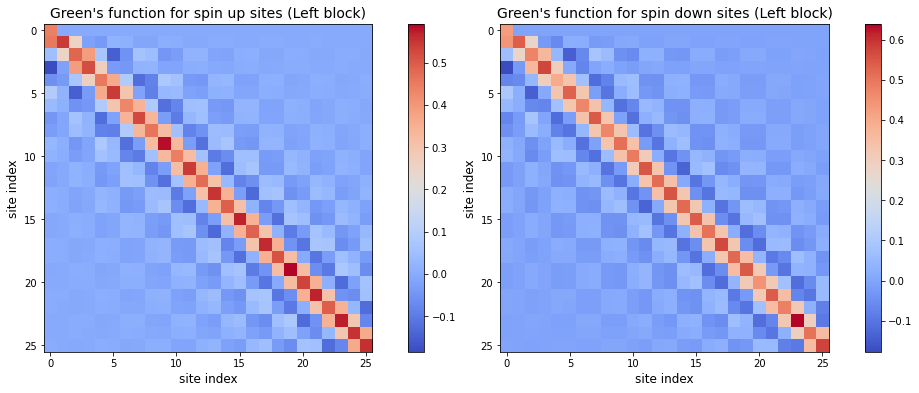

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))

im1 = ax1.imshow(G_up_L,cmap='coolwarm')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax1.set_title("Green's function for spin up sites (Left block)", fontsize=14)
ax1.set_xlabel('site index', fontsize=12)
ax1.set_ylabel('site index', fontsize=12)
plt.colorbar(im1, cax=cax)

im2 = ax2.imshow(G_down_L,cmap='coolwarm')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax2.set_title("Green's function for spin down sites (Left block)", fontsize=14)
ax2.set_xlabel('site index', fontsize=12)
ax2.set_ylabel('site index', fontsize=12)
plt.colorbar(im2, cax=cax)

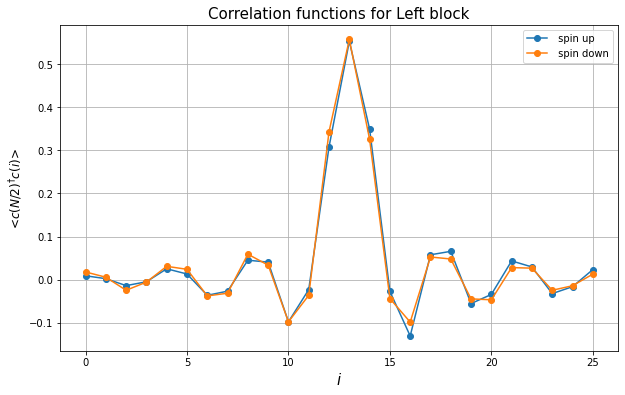

In [11]:
fig = plt.figure(figsize=(10,6))
plt.plot(G_up_L[int(max_length_left_block/2)][:],'o-',label = " spin up")
plt.plot(G_down_L[int(max_length_left_block/2)][:],'o-',label = " spin down")
plt.title("Correlation functions for Left block",fontsize=15)
plt.xlabel("$i$",fontsize=15)
plt.ylabel("<$c(N/2)^\dag c(i)$>",fontsize=12)
plt.grid()
plt.legend()

### Right block Correlation functions

### spin up: $G_{ij,\uparrow,right}$ = $<(C_{{i,\uparrow,right}}^{\dagger}C_{{j,\uparrow,right}}>$ , spin down: $ G_{ij,\downarrow,right}$ = $<(C_{{i,\downarrow,right}}^{\dagger}C_{{j,\downarrow,right}}>$

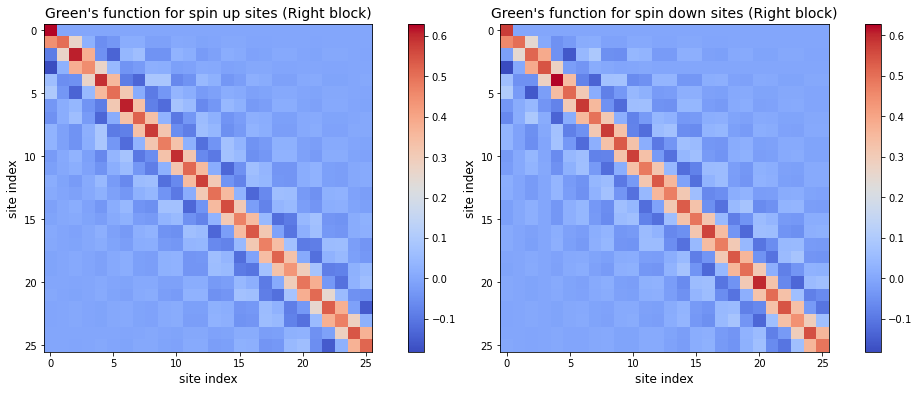

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))

im1 = ax1.imshow(G_up_R,cmap='coolwarm')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax1.set_title("Green's function for spin up sites (Right block)", fontsize=14)
ax1.set_xlabel('site index', fontsize=12)
ax1.set_ylabel('site index', fontsize=12)
plt.colorbar(im1, cax=cax)

im2 = ax2.imshow(G_down_R,cmap='coolwarm')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax2.set_title("Green's function for spin down sites (Right block)", fontsize=14)
ax2.set_xlabel('site index', fontsize=12)
ax2.set_ylabel('site index', fontsize=12)
plt.colorbar(im2, cax=cax)

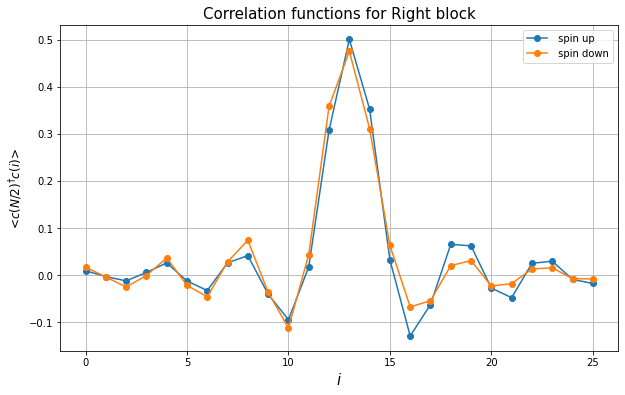

In [13]:
fig = plt.figure(figsize=(10,6))
plt.plot(G_up_R[int(max_length_left_block/2)][:],'o-',label = " spin up")
plt.plot(G_down_R[int(max_length_left_block/2)][:],'o-',label = " spin down")
plt.title("Correlation functions for Right block",fontsize=15)
plt.xlabel("$i$",fontsize=15)
plt.ylabel("<$c(N/2)^\dag c(i)$>",fontsize=12)
plt.grid()
plt.legend()

## Correlation functions between operators in Left & Right blocks

In [14]:
G_u_LR = np.zeros((max_length_left_block,max_length_left_block))
G_d_LR = np.zeros((max_length_left_block,max_length_left_block))

G_u_RL = np.zeros((max_length_left_block,max_length_left_block))
G_d_RL = np.zeros((max_length_left_block,max_length_left_block))

Psi = csr(Psi)

for i in range(max_length_left_block):
    for j in range(max_length_left_block):
        CU_LR = kron(C_dag_u_L[i],C_u_R[max_length_left_block-j-1])
        CD_LR = kron(C_dag_d_L[i],C_d_R[max_length_left_block-j-1])
        G_u_LR[i][j] = (Psi.T*CU_LR*Psi).todense()
        G_d_LR[i][j] = (Psi.T*CD_LR*Psi).todense()
        
G_u_RL = G_u_LR.T
G_d_RL = G_d_LR.T        

### Left - Right Correlation functions

### $G_{ij,\uparrow,Left-Right}$ = $<(C_{{i,\uparrow,Left}}^{\dagger}C_{{j,\uparrow,Right}}>$ ,  $ G_{ij,\downarrow,Left-Right}$ = $<(C_{{i,\downarrow,Left}}^{\dagger}C_{{j,\downarrow,Right}}>$

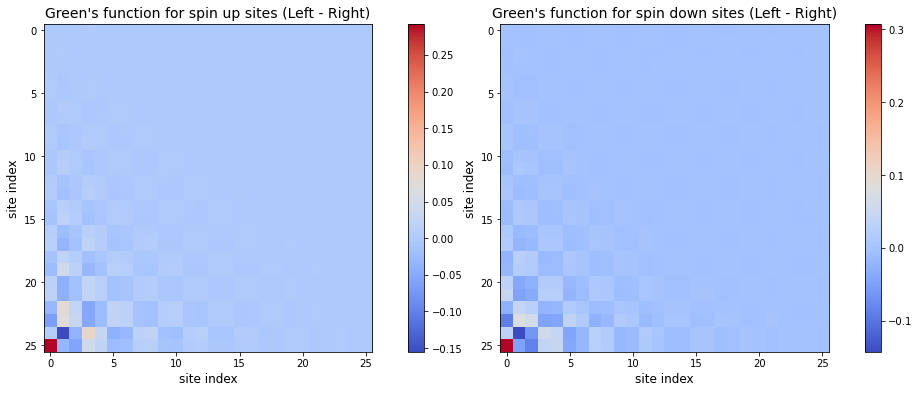

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))

im1 = ax1.imshow(G_u_LR,cmap='coolwarm')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax1.set_title("Green's function for spin up sites (Left - Right)", fontsize=14)
ax1.set_xlabel('site index', fontsize=12)
ax1.set_ylabel('site index', fontsize=12)
plt.colorbar(im1, cax=cax)

im2 = ax2.imshow(G_d_LR,cmap='coolwarm')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax2.set_title("Green's function for spin down sites (Left - Right)", fontsize=14)
ax2.set_xlabel('site index', fontsize=12)
ax2.set_ylabel('site index', fontsize=12)
plt.colorbar(im2, cax=cax)

### Right - Left Correlation functions

### $G_{ij,\uparrow,Right-Left}$ = $<(C_{{i,\uparrow,Right}}^{\dagger}C_{{j,\uparrow,Left}}>$ , $ G_{ij,\downarrow,Right-Left}$ = $<(C_{{i,\downarrow,Right}}^{\dagger}C_{{j,\downarrow,Left}}>$

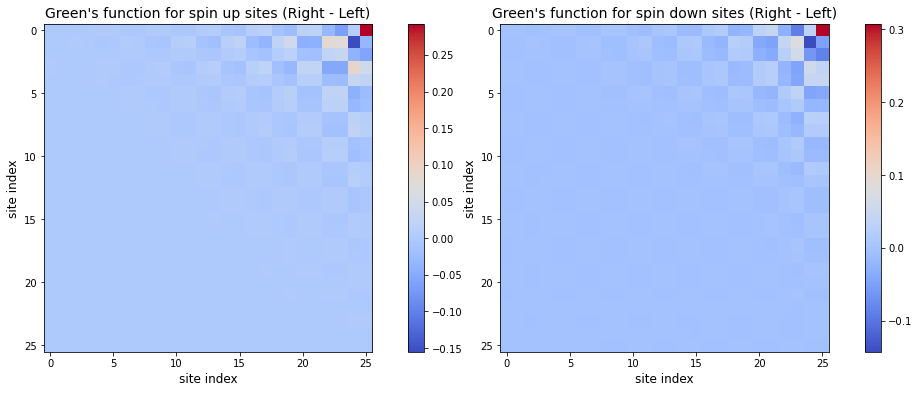

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))

im1 = ax1.imshow(G_u_RL,cmap='coolwarm')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax1.set_title("Green's function for spin up sites (Right - Left)", fontsize=14)
ax1.set_xlabel('site index', fontsize=12)
ax1.set_ylabel('site index', fontsize=12)
plt.colorbar(im1, cax=cax)

im2 = ax2.imshow(G_d_RL,cmap='coolwarm')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax2.set_title("Green's function for spin down sites (Right - Left)", fontsize=14)
ax2.set_xlabel('site index', fontsize=12)
ax2.set_ylabel('site index', fontsize=12)
plt.colorbar(im2, cax=cax)

# All  Correlation functions

In [17]:
G_up = np.zeros((System_Size,System_Size))
G_down = np.zeros((System_Size,System_Size))

for i in range(System_Size):
    for j in range(System_Size):
        
        if i < max_length_left_block and j < max_length_left_block:
            G_up[i][j] = G_up_L[i][j]
            G_down[i][j] = G_down_L[i][j]
            
        elif i >= max_length_left_block and j >= max_length_left_block:
            G_up[i][j] = G_up_R[i-max_length_left_block][j-max_length_left_block]
            G_down[i][j] = G_down_R[i-max_length_left_block][j-max_length_left_block]
            
        elif i < max_length_left_block and j > max_length_left_block:
            
            G_up[i][j] = G_u_LR[i][j-max_length_left_block]
            G_down[i][j] = G_d_LR[i][j-max_length_left_block]
            
        elif i > max_length_left_block and j < max_length_left_block:
            
            G_up[i][j] = G_u_RL[i-max_length_left_block][j]
            G_down[i][j] = G_d_RL[i-max_length_left_block][j]

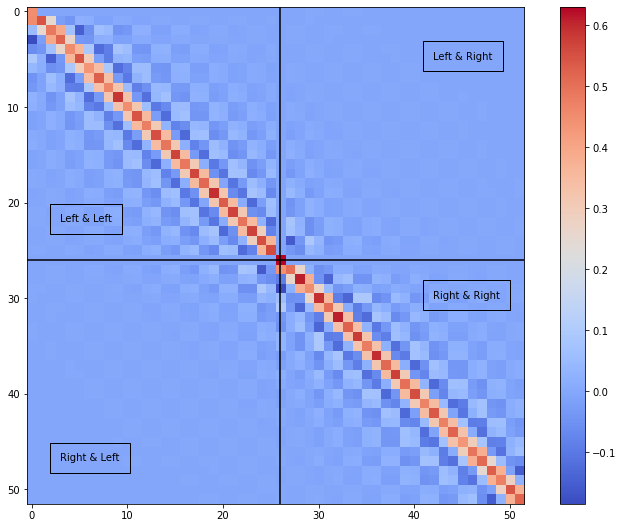

In [25]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
im = plt.imshow(G_up,cmap='coolwarm')
ax.text(3,22, 'Left & Left', bbox={'facecolor': 'none','pad': 10})
ax.text(42,5, 'Left & Right', bbox={'facecolor': 'none','pad': 10})
ax.text(3,47, 'Right & Left', bbox={'facecolor': 'none','pad': 10})
ax.text(42,30, 'Right & Right', bbox={'facecolor': 'none','pad': 10})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
ax.axhline(y=max_length_left_block, color='k')
ax.axvline(x=max_length_left_block, color='k')
plt.colorbar(im, cax=cax)